In [1]:
!nvidia-smi
!nvcc --version

Fri Jul 22 21:23:14 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.48.07    Driver Version: 512.78       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0 Off |                  N/A |
| N/A   50C    P8    14W /  N/A |      0MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version

/home/falco/miniconda3/envs/detectron2/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.12.0+cu113 True
gcc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0
Copyright (C) 2019 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [3]:
!ls -l codes/Skenario2

total 764
drwxr-xr-x 2 falco falco  36864 Jul 20 20:44 train
-rw-r--r-- 1 falco falco 679002 Jul 20 19:49 train.json
drwxr-xr-x 2 falco falco   4096 Jul 20 20:44 val
-rw-r--r-- 1 falco falco  57794 Jul 20 19:49 val.json


In [4]:
#@title Import detectron2

#@markdown You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
import tqdm

# import some common detectron2 utilities
# from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [5]:
#@title Register dataset
from detectron2.data.datasets import register_coco_instances
for d in ["train", "val"]:      
    register_coco_instances(f"Components_{d}", {}, f"codes/Skenario2/{d}.json", f"codes/Skenario2/{d}")

WARNING [07/22 21:23:31 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/22 21:23:31 d2.data.datasets.coco]: Loaded 245 images in COCO format from codes/Skenario2/train.json


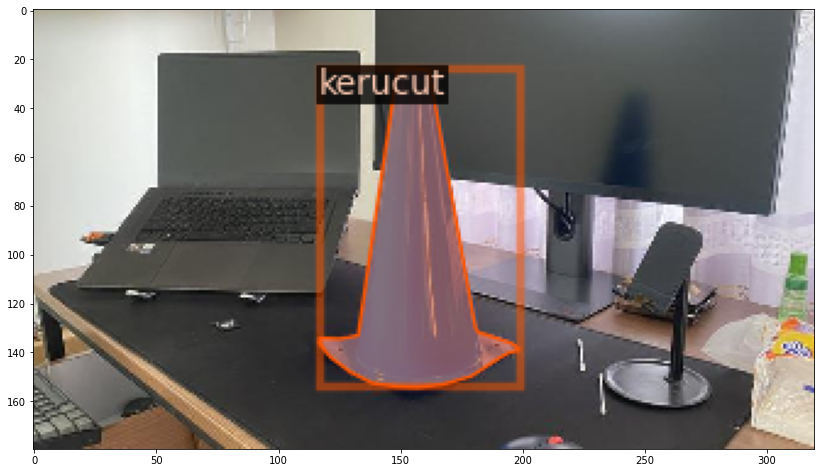

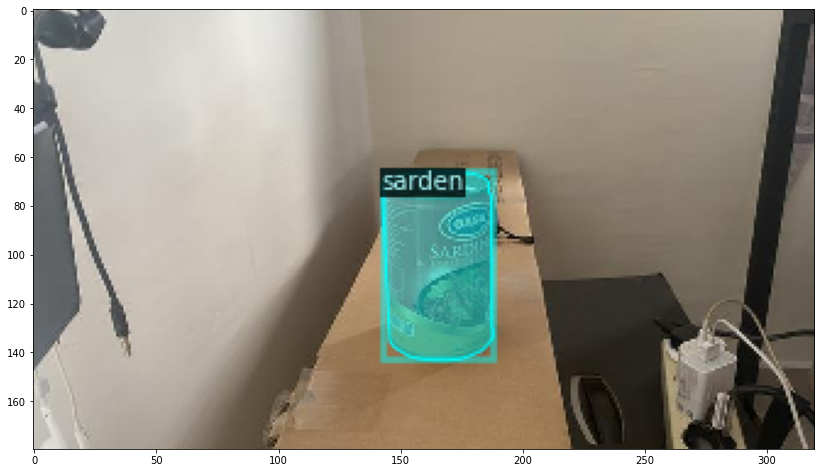

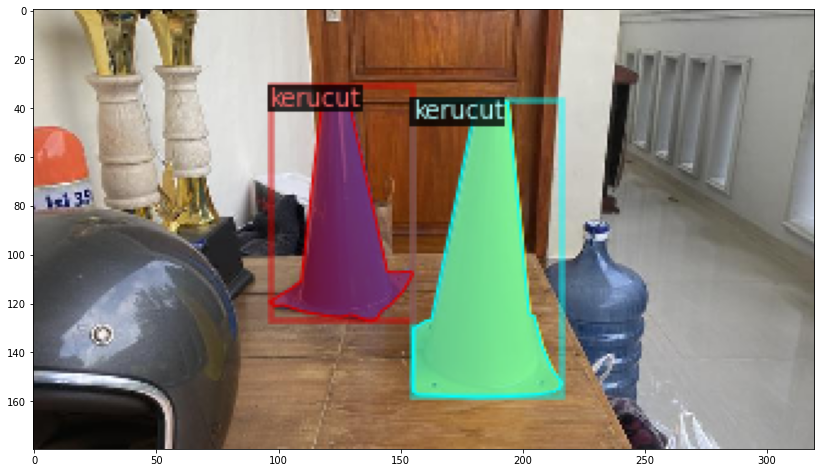

In [6]:
#@Test random dataset

import random
from detectron2.data import DatasetCatalog, MetadataCatalog

dataset_dicts = DatasetCatalog.get("Components_train")
benda_metadata = MetadataCatalog.get("Components_train")

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    v = Visualizer(img[:, :, ::-1], metadata=benda_metadata, scale=0.5)
    v = v.draw_dataset_dict(d)
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

In [ ]:
#COCO Evaluator

from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [ ]:
#@title Training (detectron2) mask_rcnn_X_101_32x8d_FPN_3x.yaml

import os
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file("detectron2/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.DATASETS.TRAIN = ("Components_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "detectron2/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1000
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2 # Jumlah classes

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
#trainer.resume_or_load(resume=True)
trainer.train()

In [ ]:
%load_ext tensorboard
%tensorboard --logdir output

In [ ]:
#test evaluation

from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator("my_dataset_test", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "my_dataset_test")
inference_on_dataset(trainer.model, val_loader, evaluator)

In [ ]:
# Config Interference Photo

cfg.MODEL.WEIGHTS = "output/model_final.pth"
cfg.DATASETS.TEST = ("Components_val", )
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
predictor = DefaultPredictor(cfg)
test_metadata = MetadataCatalog.get("Components_train")

WARNING [07/20 20:48:41 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/20 20:48:41 d2.data.datasets.coco]: Loaded 245 images in COCO format from codes/Skenario2/train.json


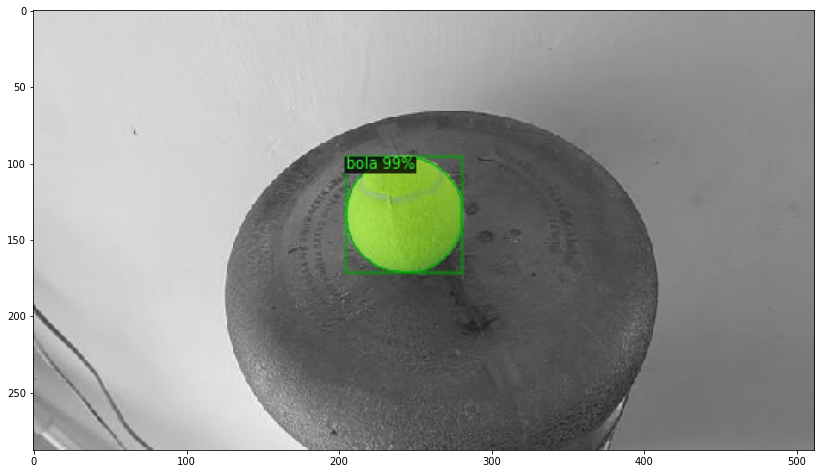

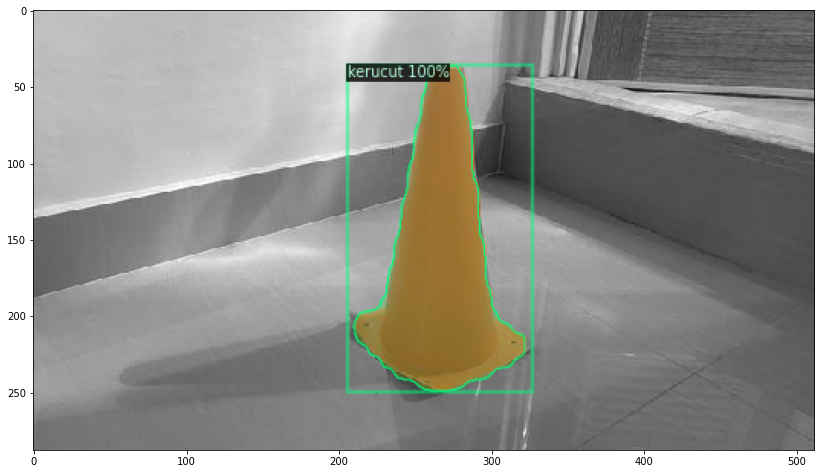

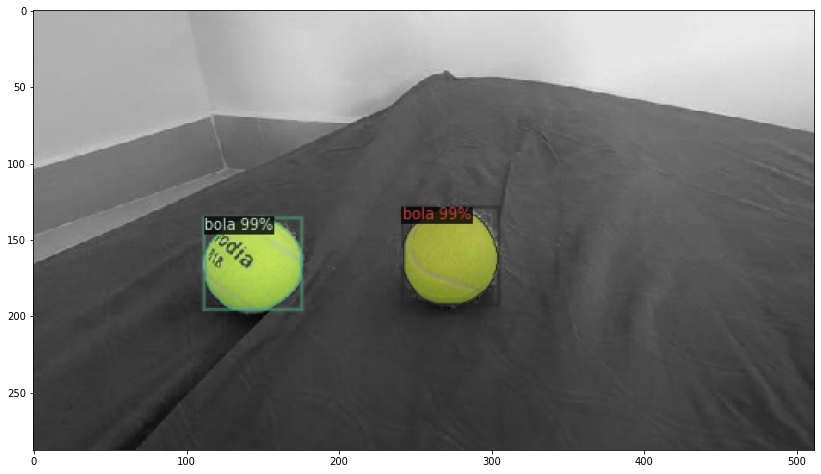

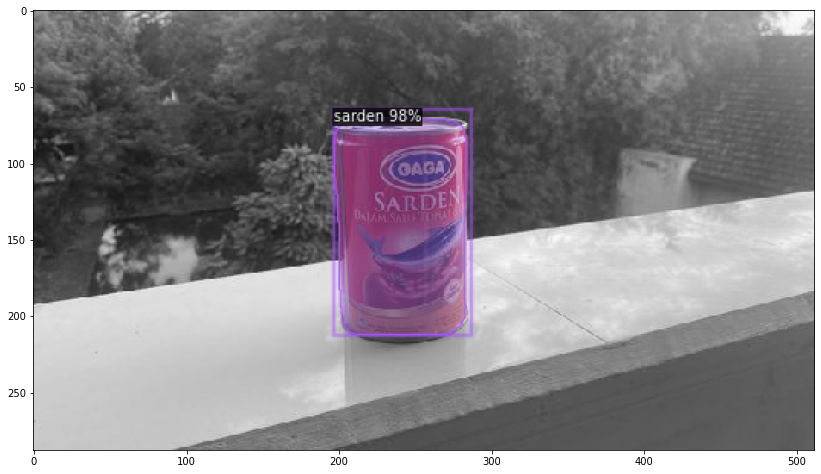

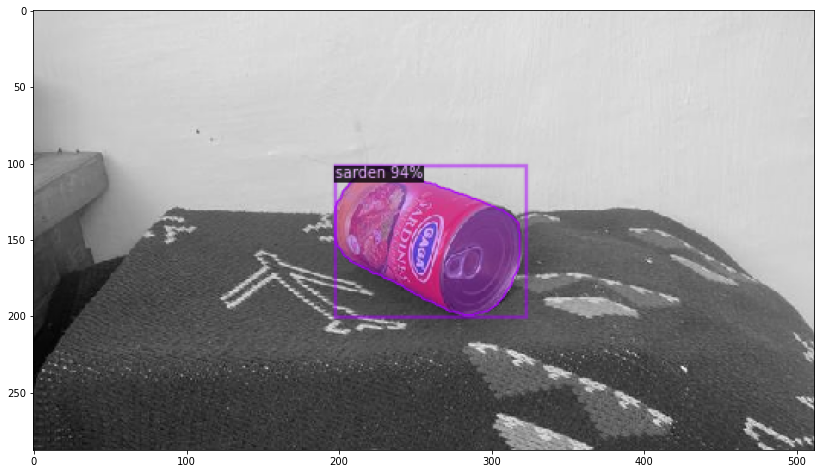

In [11]:
# Interference Photo

from detectron2.utils.visualizer import ColorMode
dataset_dicts = DatasetCatalog.get("Components_train")
for d in random.sample(dataset_dicts, 5):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=test_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

In [ ]:
# Hanya test Camera

camera = cv2.VideoCapture('http://Cartensz-PC.local:8000/camera/mjpeg?type=.mjpg')

while True:
    ret, frame = camera.read()
    cv2.imshow('frame',frame)
    if cv2.waitKey(1) == ord('q'):
        break
camera.release()
cv2.destroyAllWindows()

In [7]:
# Update Datasets Metadata

import os
from detectron2.utils.video_visualizer import VideoVisualizer
from detectron2.utils.visualizer import ColorMode

WINDOW_NAME = "Bismillah"

cfg = get_cfg()
cfg.merge_from_file("detectron2/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.WEIGHTS = "codes/model_final_ske2.pth"
cfg.DATASETS.TEST = ("Components_val", )
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3 # Jumlah classes

predictor = DefaultPredictor(cfg)
test_metadata = MetadataCatalog.get("Components_train")
cpu_device = torch.device("cpu")

[07/22 21:23:49 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

In [8]:
test_metadata.get("thing_classes")

['bola', 'kerucut', 'sarden']

In [14]:
# Inisialisasi Interference Video

def _frame_from_video(video):
    while video.isOpened():
        success, frame = video.read()
        if success:
            yield frame
        else:
            break

def run_on_video(video):
    video_visualizer = VideoVisualizer(test_metadata, instance_mode=ColorMode.IMAGE)
    
    def process_predictions(frame, predictions):
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            
        predictions = predictions["instances"].to(cpu_device)
        vis_frame = video_visualizer.draw_instance_predictions(frame, predictions)

        # Converts Matplotlib RGB format to OpenCV BGR format
        vis_frame = cv2.cvtColor(vis_frame.get_image(), cv2.COLOR_RGB2BGR)
        return vis_frame

    frame_gen = _frame_from_video(video)
    for frame in frame_gen:
        yield process_predictions(frame, predictor(frame))

In [15]:
# Interference Video 1 (Oke)

cam = cv2.VideoCapture('http://Cartensz-PC.local:8000/camera/mjpeg?type=.mjpg')

for vis in tqdm.tqdm(run_on_video(cam)):
    cv2.namedWindow(WINDOW_NAME, cv2.WINDOW_NORMAL)
    cv2.imshow(WINDOW_NAME, vis)
    if cv2.waitKey(1) == 27:
        break  # esc to quit
cam.release()
cv2.destroyAllWindows()

90it [00:35,  2.52it/s]


In [12]:
# Interference Video 2 (Oke)

cap = cv2.VideoCapture('http://Cartensz-PC.local:8000/camera/mjpeg?type=.mjpg')

while cap.isOpened():
    ret, image = cap.read()
        
    outputs = predictor(image)

    v = Visualizer(image[:, :, ::-1], metadata=test_metadata, scale=1.2)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2.imshow(WINDOW_NAME, v.get_image()[:, :, ::-1])
    if cv2.waitKey(1) == 27:
        break  # esc to quit
cap.release()
cv2.destroyAllWindows()